In [1]:
import numpy             as np
import pandas            as pd
import tables            as tb
import scipy.stats       as st
import matplotlib.pyplot as plt

from nbtools import auto_plot_style
from jupyfun import progressbar

in_range = lambda x, a, b: (x>=a) & (x<b)

In [2]:
#%matplotlib inline
auto_plot_style()

# Individual SiPMs 

In [157]:
# distances in mm, energies in eV
wire_pitch       = 5
wire_diam        = 1e-2
wire_r           = wire_diam/2
sipm_size        = 6.15
sipm_active_area = 6 * 6
n_sipms_per_side = 10
sipm_gap         = 0.5
el_diam          = 64
el_r             = el_diam/2
rotation         = 45 * np.pi / 180 # with respect to x=const

s = np.sin(rotation)
c = np.cos(rotation)
rotation_matrix  = np.array([c, s, -s, c]).reshape(2, 2)

In [149]:
n_wires    = 14
wire_pos   = [(i+0.5)*wire_pitch for i in range(n_wires//2)]
wire_pos   = sorted(s*p for s in (-1, 1) for p in wire_pos)
wire_pos   = np.array(wire_pos)
first_wire = wire_pos[0]

In [150]:
sipm_pos = np.array([(i+0.5) * (sipm_size + sipm_gap) for i in range(n_sipms_per_side//2)])
sipm_pos = np.stack(list(map(np.ravel, np.meshgrid(sipm_pos, sipm_pos, indexing="ij"))), axis=1)
sipm_pos = np.concatenate([sipm_pos * np.array([[i,j]]) for i in (-1, 1) for j in (-1, 1)])

/tmp/ipykernel_87152/2782890417.py:9: RuntimeWarning: invalid value encountered in scalar power
  edge = (el_r**2 - x**2)**0.5


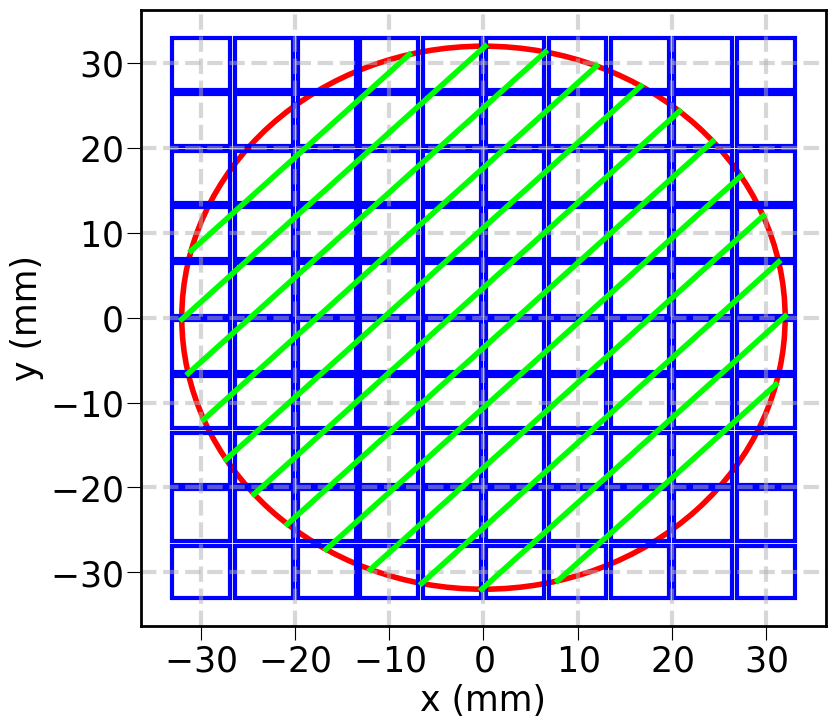

In [7]:
c = plt.Circle((0,0), el_r, facecolor="None", edgecolor="r", lw=4)
plt.gca().add_patch(c)

for pos in sipm_pos - sipm_size/2:
    r = plt.Rectangle(pos, sipm_size, sipm_size, facecolor="None", edgecolor="b", zorder=1)
    plt.gca().add_patch(r)

for x in wire_pos:
    edge = (el_r**2 - x**2)**0.5
    x0, y0 = rotate(x, -edge, -rotation)
    x1, y1 = rotate(x,  edge, -rotation)
    plt.plot([x0, x1], [y0, y1], color="lime", zorder=2, lw=4)
#plt.vlines(wire_pos, -el_r, el_r, color="lime", zorder=2, lw=4)

plt.xticks(np.arange(-30, 31, 10))
plt.yticks(np.arange(-30, 31, 10))
plt.xlabel("x (mm)")
plt.ylabel("y (mm)")
plt.gca().set_aspect(.9)
plt.grid()

#### Fill factor

In [8]:
n   = 10**7
rho = np.random.uniform(0, el_r**2, n)**0.5
phi = np.random.uniform(0, 2*np.pi, n)
xy0 = np.stack([rho*np.cos(phi), rho*np.sin(phi)], axis=1)
xyr = np.abs(xy0) % (sipm_size + sipm_gap) - sipm_gap/2
ok  = np.all(in_range(xyr, 0, sipm_size), axis=1)
sipm_fill_factor = np.count_nonzero(ok) / n
overall_fill_factor = sipm_fill_factor * sipm_active_area / sipm_size**2
sipm_fill_factor, overall_fill_factor

(0.8572135, 0.8159081499107673)

# Light emission

In [151]:
el_range    = 4e-2
dep_energy  = 41.5e3
w_i         = 15.6
n_ie        = dep_energy/w_i
light_yield = 300
cloud_diam  = 4e-2
cloud_r     = cloud_diam/2
fano_factor = 0.05
d_wire_sipm = 10
print("Forward-emitted photonsn_per event", int(n_ie*light_yield/2))

Forward-emitted photonsn_per event 399038


In [15]:
sipm_bins = []
for p in sorted(np.unique(sipm_pos.T[0])):
    sipm_bins.extend([p-sipm_size/2, p+sipm_size/2])
sipm_bins = np.array(sipm_bins)

extent = (sipm_bins.min(), sipm_bins.max())*2
ticks  = np.arange(-30, 31, 10)

In [134]:
fine_bins = np.linspace(-el_r, el_r, 200)

In [179]:
def generate_electrons(n_ave):
    if n_ave<10:
        return np.random.poisson(n_ave)
    else:
        return int(np.round(np.random.normal(n_ave, fano_factor*n_ave**0.5)))

def distribute_charge(x0, y0, n):
    r0 = np.random.uniform(0, cloud_r**2, n)
    p0 = np.random.uniform(0,    2*np.pi, n)
    x0 = r0 * np.cos(p0) + x0
    y0 = r0 * np.sin(p0) + y0
    dx           = x0[:, np.newaxis] - wire_pos
    closest_wire = np.argmin(np.abs(dx), axis=1)
    dxr          = dx[np.arange(n), closest_wire]
    
    r   = np.random.uniform(0, el_range, n) + wire_r
    phi = np.pi * (dxr/wire_pitch - 0.5)
    x   = r * np.cos(phi) + wire_pos[closest_wire]
    z   = r * np.sin(phi)
    y   = np.full(n, y0)
    return np.stack([x,y,z], axis=1), closest_wire

def is_shadowed(p0, pwire, cos_th, phi):
    sin_th = (1.0 - cos_th**2)**0.5 # shape (n,)
    axis   = (pwire - p0)[::2][np.newaxis] # remove y component shape (1,2)
    ray    = np.array([sin_th * np.cos(phi), cos_th]).T # shape (n,2)

    a = np.sum( ray *  ray, axis=1)
    b = np.sum( ray * axis, axis=1) # negative sign irrelevant, factor 2 factored out
    c = np.sum(axis * axis, axis=1) - wire_r**2
    return b*b >= a*c

def simulate_el(xyz0, n_wire, ly=light_yield):
    # we only simulate those photons going forward
    nph = np.random.poisson(ly/2)
    
    cth = np.random.uniform(0,       1, size=nph)
    phi = np.random.uniform(0, 2*np.pi, size=nph)

    xyz_wire = np.array([wire_pos[n_wire], 0, 0])
    shadowed = is_shadowed(xyz0, xyz_wire, cth, phi)

    tth  = (cth[~shadowed]**-2 - 1)**0.5
    z    = d_wire_sipm + xyz0[-1]
    phi  = phi[~shadowed]
    x    = z * tth * np.cos(phi)
    y    = x       * np.tan(phi)
    return np.array([x+xyz0[0], y + xyz0[1]]).T

def rotate_hits(hits):
    return rotation_matrix.dot(hits.T).T

def count_hits(xy):
    hits = st.binned_statistic_2d(*xy.T, None, "count", [sipm_bins, sipm_bins])[0]
    hits = hits[::2, ::2]
    return hits

### Demo

[[ 2.48698324e+00  1.11961681e-04 -8.20189488e-04]
 [ 2.48760088e+00 -7.48747315e-05 -7.79926134e-04]
 [ 2.47178280e+00  7.01300565e-06 -1.77599807e-03]
 [ 2.46381648e+00 -4.91004804e-05 -2.27635044e-03]
 [ 2.48318409e+00 -4.72506480e-05 -1.05775984e-03]
 [ 2.45849106e+00  6.42743088e-05 -2.60788877e-03]
 [ 2.48234785e+00 -8.16501080e-05 -1.10951268e-03]
 [ 2.48986679e+00  6.62976402e-05 -6.37987345e-04]
 [ 2.45524678e+00 -2.84618561e-04 -2.81692910e-03]
 [ 2.45651355e+00 -3.43180931e-05 -2.73291889e-03]] [7 7 7 7 7 7 7 7 7 7]


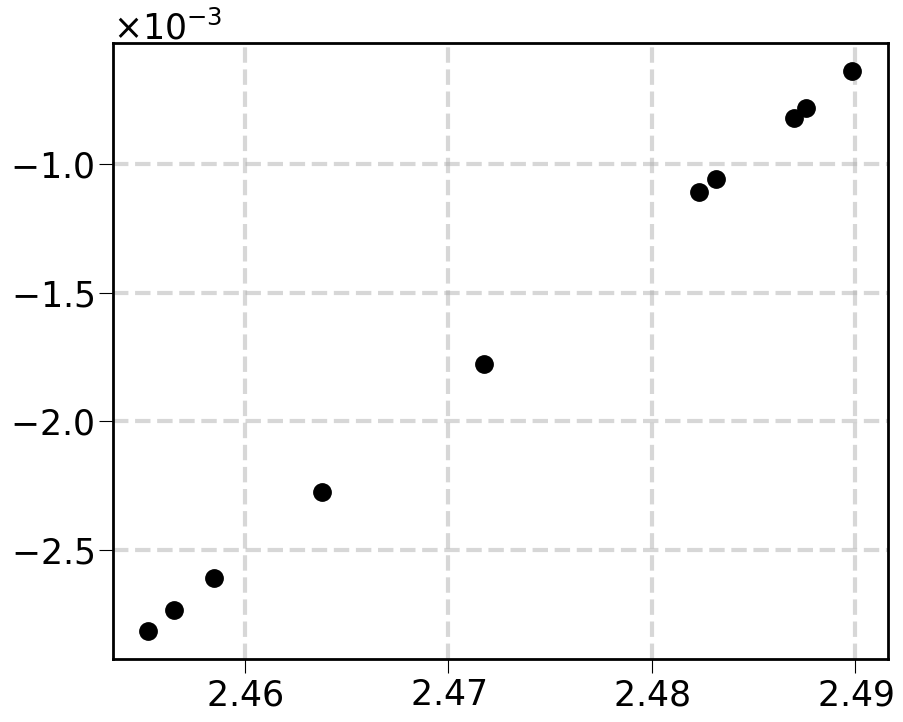

In [36]:
x0, y0 = 0.1, 0.0
xyz, wires = distribute_charge(x0, y0, 10)
print(xyz, wires)

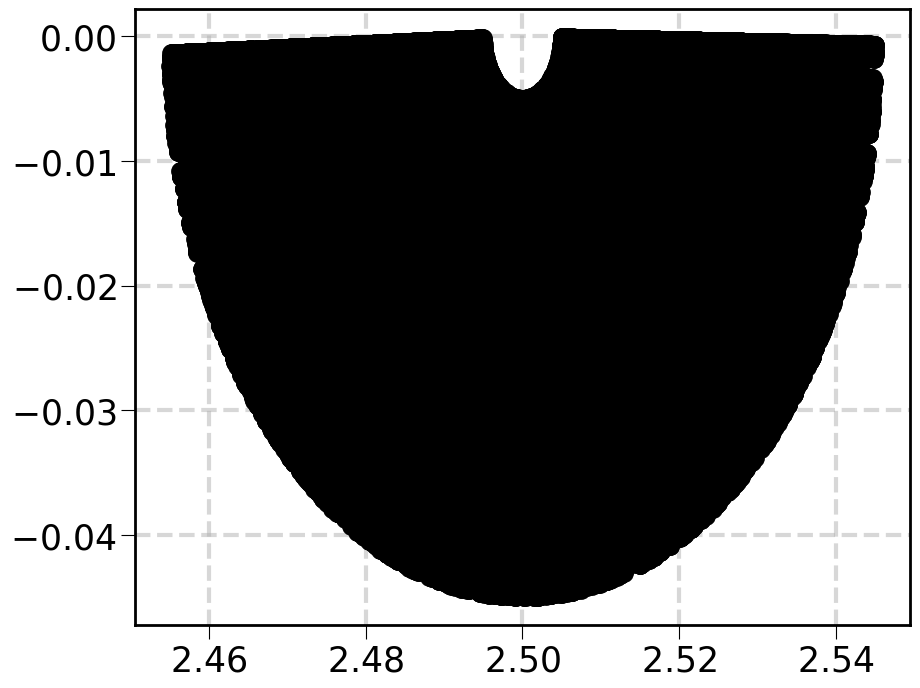

In [41]:
x0 = np.random.uniform(cloud_r, wire_pitch-cloud_r, 500)
x, z = [], []
for x0i in x0:
    out =  distribute_charge(x0i, 0., 500)[0].T
    x.extend(out[0])
    z.extend(out[2])

plt.plot(x, z, ".k")
plt.grid()

In [135]:
xyz0     = np.array([2.5, 0., -2.])
xyz_wire = np.array([2.5, 0.,  0.])
is_shadowed(xyz0, xyz_wire, np.ones(1), np.zeros(1))

array([ True])

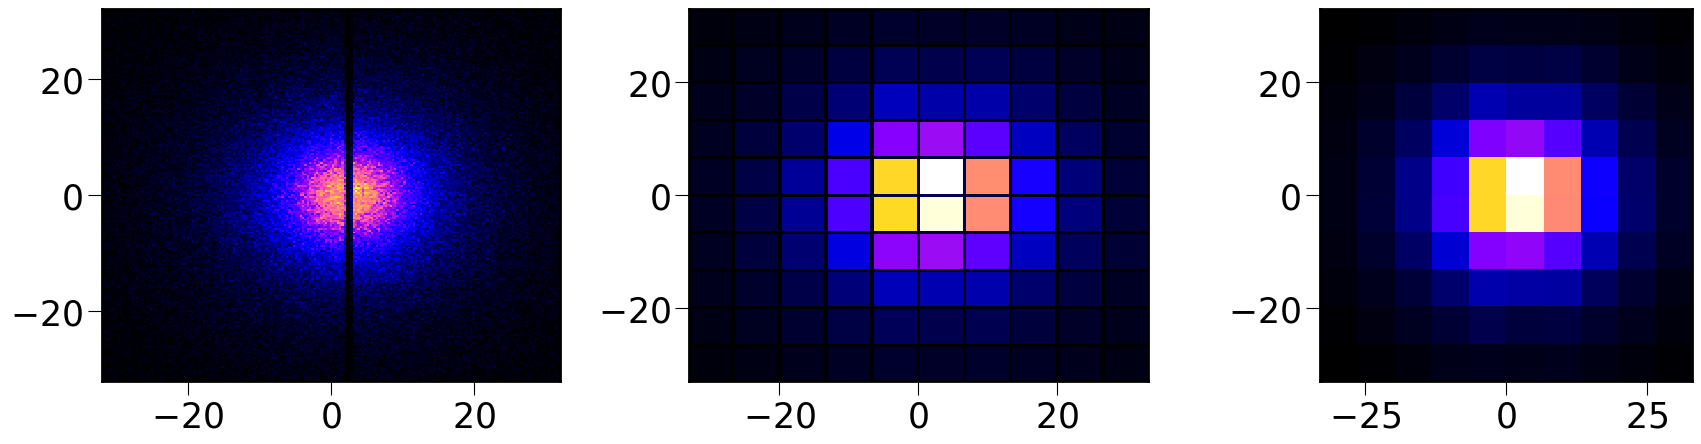

In [163]:
xy   = np.array([2.5, 0.0, -20*wire_r])
hits = simulate_el(xy, 7, 10**6)
img  = count_hits(hits)
plt.figure(figsize=(18, 5))
plt.subplot(1, 3, 1); plt.hist2d(*hits.T, fine_bins);
plt.subplot(1, 3, 2); plt.hist2d(*hits.T, sipm_bins);
plt.subplot(1, 3, 3); plt.imshow(  img.T, origin="lower", extent=extent);
plt.tight_layout()

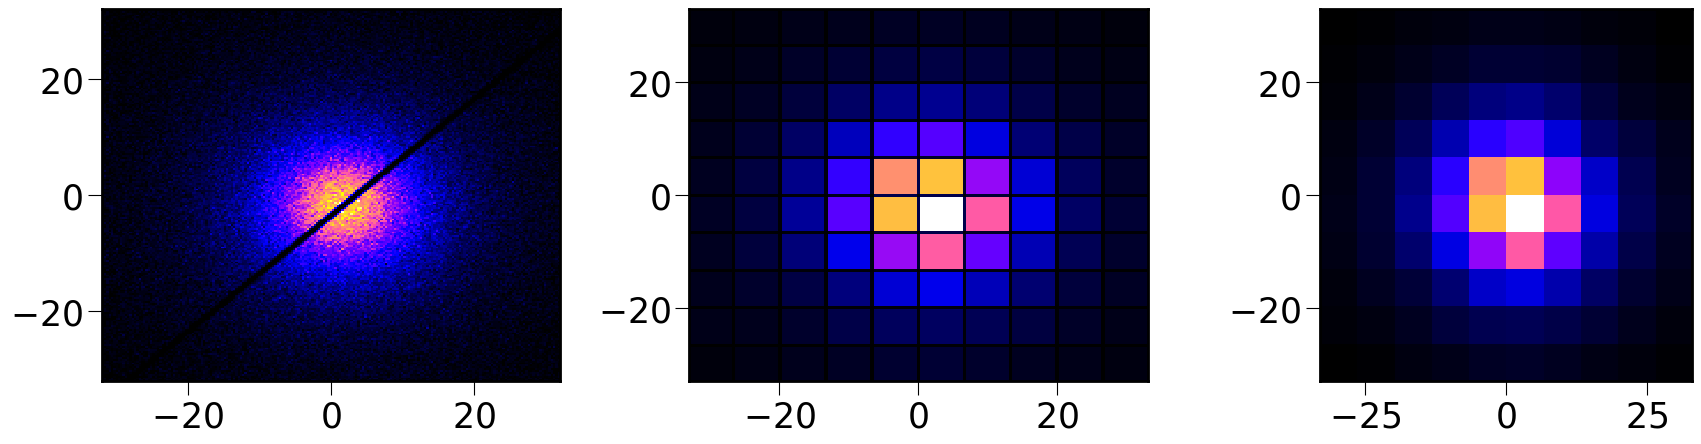

In [164]:
xy   = np.array([2.5, 0.0, -20*wire_r])
hits = simulate_el(xy, 7, 10**6)
hits = rotate_hits(hits)
img  = count_hits(hits)
plt.figure(figsize=(18, 5))
plt.subplot(1, 3, 1); plt.hist2d(*hits.T, fine_bins);
plt.subplot(1, 3, 2); plt.hist2d(*hits.T, sipm_bins);
plt.subplot(1, 3, 3); plt.imshow(  img.T, origin="lower", extent=extent);
plt.tight_layout()

### Production

In [185]:
nevt = 100
r0   = np.random.uniform(0, el_r**2, nevt)**0.5
p0   = np.random.uniform(0, 2*np.pi, nevt)
x00  = r0*np.cos(p0)
y00  = r0*np.sin(p0)

In [186]:
outputfile = "images.h5"

In [189]:
import time
t0 = time.time()
with tb.open_file(outputfile, "w", complib="zlib", complevel=4) as file:
    img_store = file.create_earray(file.root, "images", atom=tb.UInt16Atom(), shape=(0, n_sipms_per_side, n_sipms_per_side))
    pos_store = file.create_earray(file.root,    "pos", atom=tb.FloatAtom() , shape=(0, 2))
    chg_store = file.create_earray(file.root, "charge", atom=tb.FloatAtom() , shape=(0, n_wires))
    
    file.create_array(file.root, "wires_pos", wire_pos, "Wire position in x")
    file.create_array(file.root, "sipms_pos", sipm_pos, "SiPM position in xY")
    for ievt, x0, y0 in progressbar(zip(range(nevt), x00, y00)):
        n           = generate_electrons(n_ie)
        xyz0, wires = distribute_charge(x0, y0, n)
        charge      = np.bincount(wires, minlength=n_wires)

        all_hits = []
        for xyz, wire in zip(xyz0, wires):
            hits = simulate_el(xyz, wire)
            all_hits.append(hits)
        hits = np.concatenate(all_hits)
        hits = rotate_hits(hits)
        img  =  count_hits(hits)
        img_store.append(   img.reshape(1, *   img.shape))
        pos_store.append(   pos.reshape(1, *   pos.shape))
        chg_store.append(charge.reshape(1, *charge.shape))

dt = time.time()-t0
print(dt, dt/nevt)

Item 100 of 100 | 0.11 s/item | ETA 0.0 min | Ellapsed 0.2 min
10.683066844940186 0.10683066844940185


In [188]:
!ls -lha $outputfile

-rw-rw-r-- 1 gonzalo gonzalo 206K abr 16 14:25 images.h5
